# Необходимые импорты

In [1]:
import numpy as np
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import scipy.special

# Методы генерации

## 1. ИКГ

Инвернсый конгруэнтный метод: как линейный, только берем обратный по модулю элемент

In [2]:
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    gcd, x, y = egcd(a, m)
    if gcd != 1:
        return None
    else:
        return x % m

def ICG(M, k, b, r_i):
    if (r_i == 0):
        return b
    return (k * modinv(r_i, M) + b) % M

## 2. CCG

Кубический конгруэнтный метод: как квадратичный, только берем еще одну степень  

In [3]:
def CCG(M, k1, k2, k3, b, r_i):
    return (k1*np.power(r_i, 3) + k2*np.power(r_i, 2) + k3*r_i + b) % M

# Генерация выборок

In [4]:
samples = {}

In [5]:
r_i = 1
k = 1
b = 1
M = 104729

all_numbers = []

for i in range(20*100):
    all_numbers.append(r_i)
    r_i = ICG(M, k, b, r_i)

samples['ICG'] = np.array(all_numbers).reshape((20, -1))

In [6]:
r_i = 1
k1 = 1
k2 = 328942
k3 = 11
b = 1
M = 104729

all_numbers = []

for i in range(20*100):
    all_numbers.append(r_i)
    r_i = CCG(M, k1, k2, k3, b, r_i)

samples['CCG'] = np.array(all_numbers).reshape((20, -1))

# Подсчет параметров

In [7]:
parameters = {'ICG': [], 'CCG': []}

In [8]:
for t in ['ICG', 'CCG']:
    for sample in samples[t]:
        p = {}
        p['mean'] = round(sample.mean(), 3)
        p['std'] = round(sample.std(), 3)
        p['cv'] = round(p['std'] / p['mean'], 3)
        parameters[t].append(p)

In [9]:
df = {f'{i+1}': parameters['ICG'][i].values() for i in range(20)}
df = pd.DataFrame(data=df, index=parameters['ICG'][0])
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean,51317.020,55095.720,54112.580,54851.800,54391.690,48893.300,50348.580,50020.870,52520.550,50035.430,54693.720,53756.160,51533.620,52830.340,52491.030,54728.030,48663.990,51576.670,53289.530,54934.870
std,29011.534,31438.316,30153.060,30511.578,29640.705,30063.013,29418.799,30501.642,31274.828,29426.324,27772.406,31316.060,28438.771,30626.752,29486.159,29456.106,28197.044,30282.604,30135.910,30063.694
cv,0.565,0.571,0.557,0.556,0.545,0.615,0.584,0.610,0.595,0.588,0.508,0.583,0.552,0.580,0.562,0.538,0.579,0.587,0.566,0.547


In [10]:
df = {f'{i+1}': parameters['CCG'][i].values() for i in range(20)}
df = pd.DataFrame(data=df, index=parameters['CCG'][0])
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean,50676.810,49101.820,49309.170,50034.310,54454.760,50627.490,60243.840,54400.500,47869.930,48193.420,52221.210,51289.000,50058.720,60651.200,55800.980,50819.590,47684.340,50526.880,50022.260,54805.160
std,29464.987,28238.844,29487.235,30838.815,29103.258,28547.826,28144.326,30722.038,30661.758,28128.713,30464.708,29723.078,28990.644,28086.541,28954.074,32126.820,28486.883,29127.947,30335.394,29315.311
cv,0.581,0.575,0.598,0.616,0.534,0.564,0.467,0.565,0.641,0.584,0.583,0.580,0.579,0.463,0.519,0.632,0.597,0.576,0.606,0.535


# Критерий $\chi^2$

Определим число интервалов:

In [11]:
N = 100
k = round(1 + np.log2(N))
print(f'k = {k}')

k = 8


Для обоих генераторов диапазон значений = {0, ..., 104728}. Разобьем его на 8 примерно равных частей:

In [12]:
interval_length = M // k
intervals = [i*interval_length for i in range(1, k+1)]
intervals

[13091, 26182, 39273, 52364, 65455, 78546, 91637, 104728]

Высчитаем значение $\chi^2$-статистики для каждой выборки:

In [13]:
chi_stat = {'ICG': [], 'CCG': []}
for t in ['ICG', 'CCG']:
    for sample in samples[t]:
        freq = [0]*k
        for elem in sample:
            for i in range(k):
                if elem <= intervals[i]:
                    freq[i] += 1
                    break
        sum = 0
        for i in range(k):
            sum += k*np.power(freq[i], 2)
        chi_stat[t].append(round(sum/N - N, 3))

In [14]:
percents = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
percent_points = np.array([1.239, 2.167, 4.255, 6.346, 9.037, 14.07, 18.48])

In [15]:
for i, val in enumerate(chi_stat['ICG']):
    if (val < percent_points[0]) or (val > percent_points[-1]):
        print(f"Выборка №{i+1}{' ' if i < 9 else ''}  противоречит гипотезе о случайности и равномерности ГПСЧ")
    else:
        print(f"Выборка №{i+1}{' ' if i < 9 else ''} не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью {percents[np.argmin(abs(percent_points - val))]}")

Выборка №1  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.25
Выборка №2  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.25
Выборка №3  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.75
Выборка №4  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.05
Выборка №5  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.5
Выборка №6  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.95
Выборка №7  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.05
Выборка №8  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.05
Выборка №9  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.05
Выборка №10 не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.05
Выборка №11 не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятн

In [16]:
for i, val in enumerate(chi_stat['CCG']):
    if (val < percent_points[0]) or (val > percent_points[-1]):
        print(f"Выборка №{i+1}{' ' if i < 9 else ''}  противоречит гипотезе о случайности и равномерности ГПСЧ")
    else:
        print(f"Выборка №{i+1}{' ' if i < 9 else ''} не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью {percents[np.argmin(abs(percent_points - val))]}")

Выборка №1  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.75
Выборка №2  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.75
Выборка №3  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.5
Выборка №4  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.25
Выборка №5  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.5
Выборка №6  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.75
Выборка №7  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.95
Выборка №8  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.25
Выборка №9  не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.75
Выборка №10 не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятностью 0.95
Выборка №11 не противоречит гипотезе о случайности и равномерности ГПСЧ с вероятно

# NIST

Сгенерируем каждым алгоритмом выборку из 0 и 1 размерности 1000000 и воспользуемся NIST-тестами (реализации брал [здесь](https://nvlpubs.nist.gov/nistpubs/legacy/sp/nistspecialpublication800-22r1a.pdf))

In [17]:
n = 100000
binary_sample = {'ICG': [], 'CCG': []}

In [18]:
r_i = 1
k = 1
b = 1
M = 104729

for i in range(n):
    binary_sample['ICG'].append(r_i % 2)
    r_i = ICG(M, k, b, r_i)

In [19]:
r_i = 1
k1 = 1
k2 = 328942
k3 = 11
b = 1
M = 104729

for i in range(n):
    binary_sample['CCG'].append(r_i % 2)
    r_i = CCG(M, k1, k2, k3, b, r_i)

In [20]:
binary_sample['ICG'] = np.array(binary_sample['ICG'])
binary_sample['CCG'] = np.array(binary_sample['CCG'])

## 1. Частотный побитовый тест

In [21]:
def monobit_test(input, n):
    count0 = np.sum(input == 0)
    count1 = np.sum(input == 1)
    S_n = count1 - count0
    S_obs = abs(S_n) / np.sqrt(n)
    p_val = round(math.erfc(S_obs / math.sqrt(2)), 3)
    success = (p_val >= 0.01)

    return (success, p_val)

In [22]:
monobit_test(binary_sample['ICG'], n)

(True, 0.087)

In [23]:
monobit_test(binary_sample['CCG'], n)

(True, 0.077)

## 2. Частотный блочный тест

In [24]:
def freq_within_block_test(input, n, m):
    N = n // m
    pi = np.array([np.sum(input[i*m:(i+1)*m] == 1) / m for i in range(N)])
    chi_stat = 4*m*np.sum(np.power((pi - 0.5), 2))
    p_val = round(scipy.special.gammaincc(N / 2, chi_stat / 2), 2)
    success = (p_val >= 0.01)

    return (success, p_val)

In [25]:
freq_within_block_test(binary_sample['ICG'], n, 3)

(True, 0.25)

In [26]:
freq_within_block_test(binary_sample['CCG'], n, 3)

(True, 1.0)

## 3. Тест на последовательность одинаковых битов

In [27]:
def runs_test(input, n):
    pi = np.sum(input == 1) / n
    tau = 2 / np.sqrt(n)
    if abs(pi - 0.5) > tau:
        return (False, 0)
    V_n = 1
    for i in range(n-1):
        if input[i] != input[i+1]:
            V_n += 1
    numerator = abs(V_n - 2*n*pi*(1-pi))
    divisor =  2*np.sqrt(2*n)*pi*(1-pi)
    p_val = round(math.erfc(numerator / divisor), 3)
    success = (p_val >= 0.01)

    return (success, p_val)

In [28]:
runs_test(binary_sample['ICG'], n)

(False, 0.002)

In [29]:
runs_test(binary_sample['CCG'], n)

(False, 0.0)

*Выводы*: 2 из 3 тестов прошли - вполне неплохой результат для весьма простых ГПСЧ. Результам п.4 текущие результаты также не противоречат: там у нас гипотеза принималась и зачастую не с самыми высокими вероятностями.

# Время генерации

In [16]:
sizes = list(map(int, [1e+3, 5e+3, 1e+4, 5e+4, 1e+5, 5e+5, 1e+6]))

In [ ]:
ICG_times = []
CCG_times = []
STD_times = []
for size in sizes:
    r_i = 1
    k = 1
    k1 = 1
    k2 = 328942
    k3 = 11
    b = 1
    M = 104729

    start = time.perf_counter()
    for i in range(size):
        r_i = ICG(M, k, b, r_i)
    finish = time.perf_counter()
    ICG_times.append(round(finish - start, 3))

    start = time.perf_counter()
    for i in range(size):
        r_i = CCG(M, k1, k2, k3, b, r_i)
    finish = time.perf_counter()
    CCG_times.append(round(finish - start, 3))

    start = time.perf_counter()
    for i in range(size):
        random.randint(0, 104728)
    finish = time.perf_counter()
    STD_times.append(round(finish - start, 3))

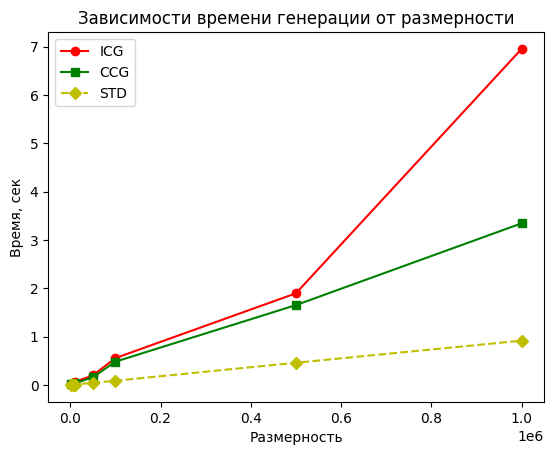

In [ ]:
plt.title('Зависимости времени генерации от размерности')
plt.xlabel('Размерность')
plt.ylabel('Время, сек')
plt.plot(sizes, ICG_times, color='r', marker='o')
plt.plot(sizes, CCG_times, color='g', marker='s')
plt.plot(sizes, STD_times, color='y', linestyle='--', marker='D')
plt.legend(['ICG', 'CCG', 'STD'])
plt.show()